🍊 **statSuma *v*.1.3.** 🍊
---


**Citation:**

Leigh R.J., Murphy R.A., and Walsh F. (2021) Paper title, Journal metrics


**Description:**

statSuma is a user-friendly script for deciding (and performing) the most appropriate statistical tests in microbiome studies 


**Please read the manual**

In [ ]:
#@title **Click here to upload a dataset file**
import io
import itertools
import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.patches as mpatches 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from google.colab import files
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import norm
from sklearn import preprocessing
from statsmodels.sandbox.stats.multicomp import multipletests

warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'figure.max_open_warning': 0})

dataset = files.upload()

In [2]:
#@title **Click here to set critical alpha values**
#@markdown This step sets the critical alpha values to determine if data is equivariant and Gaussian. This is set to **0.05** by default but can be changed to any float between 0 and 1 by clicking on this cell.

pairwise_equivariance_critical_alpha = 0.05
pairwise_gaussian_critical_alpha = 0.05
listwise_gaussian_critical_alpha = 0.05
listwise_equivariance_critical_alpha = 0.05


In [3]:
#@title **Click here to scale (normalise) data**
#@markdown Data scaling results in the cumulative reads for each sample equating to the same value. The default is **"yes"** but this can be changed by clicking on this box. 

scale_data = "yes"

def Scale(item):
    scaler = item.astype(float).sum(axis=0)/item.astype(float).sum(axis=0).max()
    scaledData = item.astype(float)/scaler
    scaledInputData = scaledData.values.tolist()
    return scaledData, scaledInputData



In [ ]:
#@title **Click here to conduct pairwise tests**

#@markdown 🍊 **The recommended pairwise test is printed below this cell when completed** 🍊

#@markdown This step computes a two-tailed Brunner-Munzel test, Mann-Whitney U-test, Welch's t-test, and Student's t-test and a two-sample Kruskal-Wallis H-test for each taxon between each pair of sites. A Bonferroni-Dunn correction (PBD) is also computed for each returned P-value. This step uses a Shapiro-Wilk test to determine data normality (whether the data was sampled from a Gaussian distribution) and a Levene's test to determine equivariance between each sample set. Gaussian likelihood and equivariance likelihood results are used to determine which pairwise test is most appropriate.

datasetName = next(iter(dataset))
dataset_df = pd.read_csv(io.BytesIO(dataset[datasetName]), sep='\t', header=None).set_index(0)
dataset_head = pd.DataFrame(dataset_df.iloc[0].tolist())
dataset_head = dataset_head.rename(columns={0:"Group"}).T #.set_index('Group')

if scale_data=="yes":
  sdata1, sdata2 = Scale(dataset_df.drop('Group'))
  sdata1 = sdata1.T.reset_index().T.drop('index')
  dataset_df = pd.concat([dataset_head, sdata1])
  #dataset_df1 = dataset_head.append(sdata1)
else:
  dataset_df = dataset_df



groupedData = dataset_df.T.groupby("Group", axis=0)
groups = set(dataset_df.iloc[0].tolist())
taxa = list(dataset_df.T.columns)[1:]

reformatted_data = []

for group in groups:
  rawDataset = groupedData.get_group(group).set_index("Group")
  for taxonID, dataSeries in rawDataset.iteritems():
    dataSeries = list(dataSeries.astype(np.float))
    x = [taxonID, group, list(dataSeries)]
    reformatted_data.append(x)

results = []
BrunnerMunzelResults = []
StudentResults = []
WelchResults = []
MannWhitneyResults = []
KruskalResults = []

combi = itertools.combinations(reformatted_data,2)
for groupA, groupB in combi:
  if (groupA[0]==groupB[0]) and (groupA[1]!=groupB[1]):
    lenA, lenB = len(groupA[2]), len(groupB[2])
    if (np.mean(groupA[2]) > 0) and (np.std(groupA[2])>0) and (np.mean(groupB[2])>0) and (np.std(groupB[2])>0) and (lenA > 1) and (lenB > 1):
      L, P = stats.levene(groupA[2], groupB[2])
      K1, KP1 = stats.shapiro(groupA[2])
      K2, KP2 = stats.shapiro(groupB[2])
      Mean1, SD1, Median1, Var1, min1, max1 = np.mean(groupA[2]), np.std(groupA[2]), np.median(groupA[2]), np.var(groupA[2]), min(groupA[2]), max(groupA[2])
      Mean2, SD2, Median2, Var2, min2, max2 = np.mean(groupB[2]), np.std(groupB[2]), np.median(groupB[2]), np.var(groupB[2]), min(groupB[2]), max(groupB[2])
      Brunner_Stat, Brunner_P = stats.brunnermunzel(groupA[2], groupB[2])
      Student_Stat, Student_P = stats.ttest_ind(groupA[2], groupB[2], equal_var=True)
      Welch_Stat, Welch_P = stats.ttest_ind(groupA[2], groupB[2], equal_var=False)
      KW_Stat, KW_P = stats.kruskal(groupA[2], groupB[2])
      MW_Stat, MW_P = stats.mannwhitneyu(groupA[2], groupB[2])
      if Mean1 > Mean2:
        MeanDifference = "Decrease"
      elif Mean1 < Mean2:
        MeanDifference = "Increase"
      else:
        MeanDifference = "NoChange"    
      if Median1 > Median2:
        MedianDifference = "Decrease"
      elif Median1 < Median2:
        MedianDifference = "Increase"
      else:
        MedianDifference = "NoChange"
      if P >= pairwise_equivariance_critical_alpha:
        equivariance = "equivariant"
      else:
        equivariance = "non-equivariant"
      if KP1 >= pairwise_gaussian_critical_alpha:
        distribution1 = "gaussian"
      else:
        distribution1 = "non-gaussian"
      if KP2 >= pairwise_gaussian_critical_alpha:
        distribution2 = "gaussian"
      else:
       distribution2 = "non-gaussian"
      ComparisonResult = [groupA[0], groupA[1], groupB[1], Mean1, SD1, Median1, Var1, lenA, min1, max1, Mean2, SD2, Median2, Var2, lenB, min2, max2, MedianDifference, Brunner_Stat, Brunner_P]
      BrunnerMunzelResults.append(ComparisonResult)
      ComparisonResult = [groupA[0], groupA[1], groupB[1], Mean1, SD1, Median1, Var1, lenA, min1, max1, Mean2, SD2, Median2, Var2, lenB, min2, max2, MedianDifference, MW_Stat, MW_P]
      MannWhitneyResults.append(ComparisonResult)
      ComparisonResult = [groupA[0], groupA[1], groupB[1], Mean1, SD1, Median1, Var1, lenA, min1, max1, Mean2, SD2, Median2, Var2, lenB, min2, max2, MedianDifference, KW_Stat, KW_P]
      KruskalResults.append(ComparisonResult)
      ComparisonResult = [groupA[0], groupA[1], groupB[1], Mean1, SD1, Median1, Var1, lenA, min1, max1, Mean2, SD2, Median2, Var2, lenB, min2, max2, MeanDifference, Student_Stat, Student_P]
      StudentResults.append(ComparisonResult)
      ComparisonResult = [groupA[0], groupA[1], groupB[1], Mean1, SD1, Median1, Var1, lenA, min1, max1, Mean2, SD2, Median2, Var2, lenB, min2, max2, MeanDifference, Welch_Stat, Welch_P]
      WelchResults.append(ComparisonResult)
      if (distribution1 == "gaussian") and (distribution2 == "gaussian") and (equivariance == "equivariant"):
        recommendation = "Students_t_test"
      elif (distribution1 == "gaussian") and (distribution2 == "gaussian") and (equivariance == "non-equivariant"):
        recommendation = "Welchs_t_test"
      elif ((distribution1 == "non-gaussian") or (distribution2 == "non-gaussian")) and (equivariance == "non-equivariant") and min(lenA,lenB)>9:
        recommendation = "Brunner-Munzel_test"
      elif ((distribution1 == "non-gaussian") or (distribution2 == "non-gaussian")) and (equivariance == "non-equivariant") and min(lenA,lenB)<9 and min(lenA,lenB)>4:
        recommendation = "Kruskal-Wallis_H_test"
      elif ((distribution1 == "non-gaussian") or (distribution2 == "non-gaussian")) and (equivariance == "equivariant") and min(lenA,lenB)>7:
       recommendation = "Mann-Whitney_U_test"
      elif min(lenA,lenB)<4 and (equivariance == "equivariant"):
        recommendation = "Size_Students_t_test"
      elif min(lenA,lenB)<4 and (equivariance == "non-equivariant"):
        recommendation = "Size_Welchs_t_test"
      else:
        "Check_statistics"
      result = [groupA[0], groupA[1], groupB[1], lenA, lenB, L, K1, K2, P, KP1, KP2, equivariance, distribution1, distribution2, recommendation]
      results.append(result)

tests_df = pd.DataFrame.from_records(results, columns=["Taxon", "GroupA", "GroupB", "SizeA", "SizeB", "Levenes_Stat", "KS_StatA", "KS_StatB", "Levenes_Pvalue", "KS_PvalueA", "KS_PvalueB", "Equivariant?", "GroupA_Gaussian?", "GroupB_Gaussian?", "Recommended_test"])
BrunnerMunzelResults_df = pd.DataFrame.from_records(BrunnerMunzelResults, columns=["Taxon", "GroupA", "GroupB", "MeanA", "StDevA", "MedianA", "VarianceA", "SizeA", "MinimumA", "MaximumA", "MeanB", "StDevB", "MedianB", "VarianceB", "SizeB", "MinimumB", "MaximumB", "Difference", "Statistic", "Pvalue"])
StudentResults_df = pd.DataFrame.from_records(StudentResults, columns=["Taxon", "GroupA", "GroupB", "MeanA", "StDevA", "MedianA", "VarianceA", "SizeA", "MinimumA", "MaximumA", "MeanB", "StDevB", "MedianB", "VarianceB", "SizeB", "MinimumB", "MaximumB", "Difference", "Statistic", "Pvalue"])
WelchResults_df = pd.DataFrame.from_records(WelchResults, columns=["Taxon", "GroupA", "GroupB", "MeanA", "StDevA", "MedianA", "VarianceA", "SizeA", "MinimumA", "MaximumA", "MeanB", "StDevB", "MedianB", "VarianceB", "SizeB", "MinimumB", "MaximumB", "Difference", "Statistic", "Pvalue"])
MannWhitneyResults_df = pd.DataFrame.from_records(MannWhitneyResults, columns=["Taxon", "GroupA", "GroupB", "MeanA", "StDevA", "MedianA", "VarianceA", "SizeA", "MinimumA", "MaximumA", "MeanB", "StDevB", "MedianB", "VarianceB", "SizeB", "MinimumB", "MaximumB", "Difference", "Statistic", "Pvalue"])
KruskalResults_df = pd.DataFrame.from_records(KruskalResults, columns=["Taxon", "GroupA", "GroupB", "MeanA", "StDevA", "MedianA", "VarianceA", "SizeA", "MinimumA", "MaximumA", "MeanB", "StDevB", "MedianB", "VarianceB", "SizeB", "MinimumB", "MaximumB", "Difference", "Statistic", "Pvalue"])

res_df = tests_df['Recommended_test'].value_counts()
set_tests = tests_df['Recommended_test'].unique()
if "Kruskal-Wallis_H_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Kruskal-Wallis H test\n***\n")
elif "Brunner-Munzel_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Brunner-Munzel test\n***\n") 
elif "Welchs_t_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Welchs t test\n***\n") 
elif "Students_t_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Students t test\n***\n") 
elif "Mann-Whitney_U_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Mann-Whitney U test\n***\n")
elif "Size_Welchs_t_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Size-based Welchs t test\n***\n") 
elif "Size_Students_t_test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Size-based Students t test\n***\n") 

if "Size_" in set_tests:
  print("\n***Warning: A \"size based\" t-test was invoked for one or more comparisons.\nThis happens when the sample size is below 5 in a given group.\nPlease check your data")

KruskalResults_df['PBD'] = multipletests(KruskalResults_df['Pvalue'], method='Bonferroni')[1]
BrunnerMunzelResults_df['PBD'] = multipletests(BrunnerMunzelResults_df['Pvalue'], method='Bonferroni')[1]
StudentResults_df['PBD'] = multipletests(StudentResults_df['Pvalue'], method='Bonferroni')[1]
WelchResults_df['PBD'] = multipletests(WelchResults_df['Pvalue'], method='Bonferroni')[1]
MannWhitneyResults_df['PBD'] = multipletests(MannWhitneyResults_df['Pvalue'], method='Bonferroni')[1]

tests_df.to_csv("RecommendedPairwiseComparisons.tsv", sep='\t', header=True, index=False)
KruskalResults_df.to_csv("KruskalPairwiseResults.tsv", sep='\t', header=True, index=False)
BrunnerMunzelResults_df.to_csv("BrunnerMunzelPairwiseResults.tsv", sep='\t', header=True, index=False)
StudentResults_df.to_csv("StudentPairwiseResults.tsv", sep='\t', header=True, index=False)
WelchResults_df.to_csv("WelchPairwiseResults.tsv", sep='\t', header=True, index=False)
MannWhitneyResults_df.to_csv("MannWhitneyPairwiseResults.tsv", sep='\t', header=True, index=False)

recTable = pd.DataFrame(tests_df['Recommended_test'].value_counts()).rename(columns={"Recommended_test":"n"})
recTable['%'] = round((recTable/recTable.sum()*100),3)
print("\n***\nThe below table shows the number of tests (n) associated with each test\nand their associated percentage of the total number of tests (%)\n***")
recTable

#dataset_df
#sdata1.T.reset_index().T.drop('index')

In [ ]:
#@title **Click here to conduct listwise tests**

#@markdown 🍊 **The recommended listwise test is printed below this cell when completed** 🍊

#@markdown This step computes an ANOVA and a Kruskal-Wallis H-test for each taxon between each pair of sites. A Bonferroni-Dunn correction (PBD) is also computed for each returned P-value. This step uses a Shapiro-Wilk test to determine data normality (whether the data was sampled from a Gaussian distribution) and a Levene's test to determine equivariance between each sample set. Gaussian likelihood and equivariance likelihood results are used to determine which listwise test is most appropriate.


ANOVA_results = []
H_results = []
listwise_results = []

for taxon in taxa:
  experimental = []
  for group in reformatted_data:
    if taxon == group[0]:
      experimental.append(group[2])
  groupings = [item for item in experimental]
  Levenes_Stat, Levenes_P = stats.levene(*groupings)
  KWS, KWP = stats.kruskal(*groupings)
  ANS, ANP = stats.f_oneway(*groupings)
  H_res = [taxon, KWS, KWP]
  ANOVA_res = [taxon, ANS, ANP]
  ANOVA_results.append(ANOVA_res)
  H_results.append(H_res)
  Gauss = []
  for group in groupings:
    KS, KP = stats.kstest(group, 'norm')
    KSP = [KS, KP]
    Gauss.append(KSP)
  KS, KP = min(Gauss)
  if (KP >= listwise_gaussian_critical_alpha) and (Levenes_P >= listwise_equivariance_critical_alpha):
    recommendation = "ANOVA"
  else:
    recommendation = "Kruskal-Wallis_H-test"
  lres = [taxon, Levenes_Stat, KS, Levenes_P, KP, recommendation]
  listwise_results.append(lres)

KruskalListwiseResults_df = pd.DataFrame.from_records(H_results, columns=["Taxon", "Statistic", "Pvalue"])
KruskalListwiseResults_df['PBD'] = multipletests(KruskalListwiseResults_df['Pvalue'], method='Bonferroni')[1]
KruskalListwiseResults_df.to_csv("KruskalListwiseResults.tsv", sep='\t', header=True, index=False)
ANOVAListwiseResults_df = pd.DataFrame.from_records(ANOVA_results, columns=["Taxon", "Statistic", "Pvalue"])
ANOVAListwiseResults_df['PBD'] = multipletests(ANOVAListwiseResults_df['Pvalue'], method='Bonferroni')[1]
ANOVAListwiseResults_df.to_csv("ANOVAListwiseResults.tsv", sep='\t', header=True, index=False)

tests_df = pd.DataFrame.from_records(listwise_results, columns=["Taxon", "Levene_Stat", "Levene_P", "min_KS_Stat", "min_KS_P", "Recommended_test"])
tests_df.to_csv("RecommendedListwiseComparisons.tsv", sep='\t', header=True, index=False)

set_tests = tests_df['Recommended_test'].unique()
if "Kruskal-Wallis_H-test" in set_tests:
  print("\n***\nThe recommended test for all comparisons is the Kruskal-Wallis H test\n***\n")
else:
  print("\n***\nThe recommended test for all comparisons is ANOVA\n***\n") 

recTable = pd.DataFrame(tests_df['Recommended_test'].value_counts()).rename(columns={"Recommended_test":"n"})
recTable['%'] = round((recTable/recTable.sum()*100),3)
print("\n***\nThe below table shows the number of tests (n) associated with each test\nand their associated percentage of the total number of tests (%)\n***")
recTable


In [ ]:
#@title **Click here to plot variance distributions**
#@markdown This step constructs comparative standardised distributions to illustrate differential variances. This step can be slow due to the volume of graphs produced (and data processed) for large and complex datasets. To speed up this process, only comparisons where the median of both datasets is greater than 0 are plotted.

scaler = preprocessing.StandardScaler()

combi = itertools.combinations(reformatted_data,2)
with PdfPages("VarianceDistributions.pdf") as pdf:
  for groupA, groupB in combi:
    if (groupA[0]==groupB[0]) and (groupA[1]!=groupB[1]):
      if (np.mean(groupA[2]) > 0) and (np.std(groupA[2])>0) and (np.mean(groupB[2])>0) and (np.std(groupB[2])>0) and (np.median(groupA[2])>0) and (np.median(groupB[2])>0):
        L, P = stats.levene(groupA[2], groupB[2])
        groupAA = scaler.fit_transform(np.array(groupA[2]).reshape(-1,1)).tolist()
        groupBB = scaler.fit_transform(np.array(groupB[2]).reshape(-1,1)).tolist()
        groupAA = list(itertools.chain(*groupAA))
        groupBB = list(itertools.chain(*groupBB))
        z = pd.DataFrame([groupAA, groupBB]).T
        ax = sns.displot(data=z, stat='probability', common_norm=False, kde='True', palette=['blue','red'], legend=None)
        plt.title(groupA[0])
        plt.xlabel('Standardised reads')
        ax2 = plt.twinx()
        ax2.set_yticks([])
        if P > pairwise_equivariance_critical_alpha :
          ax2.set_ylabel("Equivariant (P = "+str(round(P,3))+")")
        elif (P <= pairwise_equivariance_critical_alpha) and (P > 0.001):
          ax2.set_ylabel("Non-equivariant (P = "+str(round(P,3))+")")
        else:
          ax2.set_ylabel("Non-equivariant (P = "+format(P,'.3e')+")")
        handles = [mpatches.Patch(facecolor='red', label=groupA[1]),mpatches.Patch(facecolor='blue', label=groupB[1])]
        plt.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=1)
        fig=plt.gca().get_figure()
        fig.subplots_adjust(bottom=0.25)
        pdf.savefig(fig, bbox_inches='tight')
        #plt.show()
        plt.clf()
        del groupAA, groupBB
        continue
      continue

In [ ]:
#@title **Click here to plot data standardised distributions against a Gaussian distribution**
#@markdown This step constructs comparative standardised distributions to illustrate whether a given taxon at a given site was sampled from a Gaussian distribution.

matplotlib.rcParams.update({'figure.max_open_warning': 0})
scaler = preprocessing.StandardScaler()

with PdfPages("GaussianDistributions.pdf") as pdf:  
  for group in groups:
    rawDataset = groupedData.get_group(group).set_index("Group")
    for taxonID, dataSeries in rawDataset.iteritems():
      dataSeries = list(dataSeries.astype(np.float))
      if (np.mean(dataSeries) > 0) and (np.std(dataSeries)>0) and (np.median(dataSeries)>0):
        K,P = stats.shapiro(dataSeries)
        dataSeries = scaler.fit_transform(np.array(dataSeries).reshape(-1,1)).tolist()
        dataSeries = list(itertools.chain(*dataSeries))
        normal_data = np.random.normal(loc=0.0, scale=1.0, size=min(len(dataSeries)**2, 10000))
        z = pd.DataFrame([normal_data, dataSeries]).T
        ax = sns.displot(data=z, stat='probability', common_norm=False, kde='True', palette=['blue','red'], legend=None)
        plt.title(taxonID+" ("+group+")")
        plt.xlabel('Standardised reads (deviations from the mean)')
        ax2 = plt.twinx()
        ax2.set_yticks([])
        if P > pairwise_gaussian_critical_alpha:
          ax2.set_ylabel("Gaussian (P = "+str(round(P,3))+")")
        elif (P <= pairwise_gaussian_critical_alpha) and (P > 0.001):
         ax2.set_ylabel("Non-gaussian (P = "+str(round(P,3))+")")
        else:
          ax2.set_ylabel("Non-gaussian (P = "+format(P,'.3e')+")")
        handles = [mpatches.Patch(facecolor='red', label=taxonID),mpatches.Patch(facecolor='blue', label="Gaussian distribution")]
        plt.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2)
        fig=plt.gca().get_figure()
        fig.subplots_adjust(bottom=0.25)
        pdf.savefig(fig, bbox_inches='tight')
        #plt.show()
        plt.clf()
        

In [ ]:
#@title **Click here to plot QQ-plots**
#@markdown This step constructs comparative standardised distributions to illustrate whether a given taxon at a given site was sampled from a Gaussian distribution (presented in a linear QQ-plot format).


with PdfPages("QQ_plots.pdf") as pdf:  
  for group in groups:
    rawDataset = groupedData.get_group(group).set_index("Group")
    for taxonID, dataSeries in rawDataset.iteritems():
      if (np.mean(dataSeries) > 0) and (np.std(dataSeries)>0) and (np.median(dataSeries)>0):        
        dataSeries = np.array(dataSeries.astype(np.float))
        K,P = stats.shapiro(dataSeries)
        sm.qqplot(dataSeries, stats.norm, fit=True, line='45', loc=np.mean(dataSeries), scale=np.std(dataSeries))
        ax2 = plt.twinx()
        ax2.set_yticks([])
        if P > pairwise_gaussian_critical_alpha:
          ax2.set_ylabel("Gaussian (P = "+str(round(P,3))+")")
        elif (P <= pairwise_gaussian_critical_alpha) and (P > 0.001):
          ax2.set_ylabel("Non-gaussian (P = "+str(round(P,3))+")")
        else:
          ax2.set_ylabel("Non-gaussian (P = "+format(P,'.3e')+")")
        plt.title(taxonID+" ("+group+")")
        handles = [mpatches.Patch(facecolor='red', label="QQ-line (45 degrees)"),mpatches.Patch(facecolor='blue', label=taxonID)]
        plt.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=2)
        fig=plt.gca().get_figure()
        fig.subplots_adjust(bottom=0.25)
        pdf.savefig(fig, bbox_inches='tight')
        #plt.show()
        plt.clf()

**Accessing output files**

Once all desired cells have been successfully ran, output files are accessed by clicking on the **folder** icon at the left of the screen. Below is a static image of the **folder** icon. 

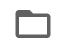